In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import cv2
import pandas as pd
from torch.optim import Adam
import random
from tqdm import tqdm
import segmentation_models_pytorch as smp

## Data Loading

In [3]:
name_files = os.listdir('data_aug/images/')
print(type(name_files))
print(len(name_files))
df = pd.DataFrame()
df['name'] = name_files
print(df.head())
df.to_csv('names.csv', index= False)

shuffle_names = name_files.copy()
random.shuffle(shuffle_names)
print(shuffle_names[0:10])

df1 = pd.DataFrame()
df1['name'] = shuffle_names
df1.to_csv('names1.csv', index=False)

<class 'list'>
34920
             name
0    case_0_0.png
1    case_0_1.png
2   case_0_10.png
3  case_0_100.png
4  case_0_101.png
['case_M_28_14.png', 'case_Y_114_64.png', 'case_M_155_78.png', 'case_R_156_13.png', 'case_M_95_9.png', 'case_M_115_19.png', 'case_Y_48_1.png', 'case_71_17.png', 'case_Y_158_8.png', 'case_53_97.png']


In [2]:
class CTDataset(Dataset):
    def __init__(self, data, img_width = 192, img_height = 192):
        super().__init__()
        self.data = data
        self.img_width = img_width
        self.img_height = img_height
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = cv2.imread('data_aug/images/' + self.data[index], 0)
        img_label = cv2.imread('data_aug/labels/' + self.data[index], 0)
        
        img = cv2.resize(img, (self.img_width, self.img_height), interpolation = cv2.INTER_AREA)
        img_label = cv2.resize(img_label, (self.img_width, self.img_height), interpolation = cv2.INTER_AREA)

        img = img/255.0
        img = np.expand_dims(img, 0)
        img_label = img_label/127
        img_label = img_label.astype('uint8')
        #img_label = np.expand_dims(img_label, 0)

        img = torch.as_tensor(img, dtype=torch.float32)
        img_label = torch.as_tensor(img_label, dtype=torch.int32)

        return img, img_label

In [4]:
df1 = pd.read_csv('names1.csv')
shuffle_names = list(df1['name'])

train_data = shuffle_names[0: int(0.7*len(shuffle_names))]
test_data = shuffle_names[int(0.7*len(shuffle_names)):int(0.8*len(shuffle_names))]
validation_data = shuffle_names[int(0.8*len(shuffle_names)):]

print('Traning dataset size = ', len(train_data), ' images')
print('Testing dataset size = ', len(test_data), ' images')
print('Validation dataset size = ', len(validation_data), ' images')

train_data = CTDataset(train_data, 64, 64)
test_data = CTDataset(test_data, 64, 64)
validation_data = CTDataset(validation_data, 64, 64)

train_data_loader = DataLoader(train_data, batch_size=128)
validation_data_loader = DataLoader(validation_data, batch_size=64)
test_data_loader = DataLoader(test_data, batch_size=32)


Traning dataset size =  24444  images
Testing dataset size =  3492  images
Validation dataset size =  6984  images


## UNet Architecture and Loss functions

In [5]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.conv = Conv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up_sample = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2)
        self.conv = Conv(in_channels=in_channels, out_channels=out_channels)
    
    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim = 1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, out_classes = 3):
        super(UNet, self).__init__()
        self.down_c1 = DownBlock(1, 32) ## sz = (128, 32, )
        self.down_c2 = DownBlock(32, 64)
        self.down_c3 = DownBlock(64, 128)

        self.bottom = Conv(128, 256)

        self.up_c1 = UpBlock(256, 128)
        self.up_c2 = UpBlock(128, 64)
        self.up_c3 = UpBlock(64, 32)
        
        self.conv_final = nn.Conv2d(32, out_channels=out_classes, kernel_size=1)

    def forward(self, x):
        x, skip_out1 = self.down_c1(x)
        x, skip_out2 = self.down_c2(x)
        x, skip_out3 = self.down_c3(x)
    
        x = self.bottom(x)
        
        x = self.up_c1(x, skip_out3)
        x = self.up_c2(x, skip_out2)
        x = self.up_c3(x, skip_out1)

        x = self.conv_final(x)
        return x


## Training

In [8]:
unet = torch.load('model3.pth')
optimizer = torch.optim.Adam(unet.parameters(), lr = 1e-4)
optimizer.load_state_dict(torch.load('optimizer3.pth'))

criteria_1 = nn.CrossEntropyLoss()
EPOCH = 50

In [ ]:
Loss_train = []
Loss_val = []
for i in range(EPOCH):
    loop = tqdm(train_data_loader)
    loss_train = 0
    loss_val = 0
    for idx, (images, labels) in enumerate(loop):
        y_pred = unet(images)
        labels = labels.long()
        loss = criteria_1(y_pred, labels)
        loss_train += loss.detach().numpy()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    Loss_train.append(loss_train)

    loop = tqdm(validation_data_loader)
    with torch.no_grad():
        for idx, (images, labels) in enumerate(loop):
            y_pred = unet(images)
            labels = labels.long()
            loss = criteria_1(y_pred, labels)
            loss_val += loss.detach().numpy()
    Loss_val.append(loss_val)

    print(f"Epoch {i}/{EPOCH} ---->>>>> Training Loss = {loss_train*128/len(train_data)} |||| Validation Loss = {loss_val*64/len(validation_data)}")
    print('\n')
    torch.save(unet.state_dict(), 'model3_w.pth')
    torch.save(optimizer.state_dict(), 'optimizer3.pth')
    torch.save(unet, 'model3.pth')

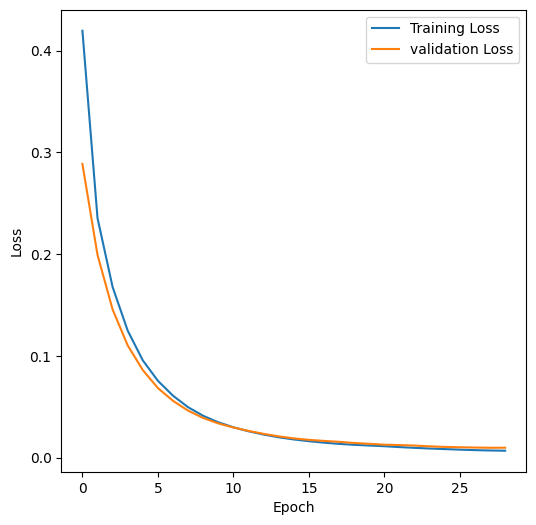

In [24]:
plt.figure(figsize=(6, 6))
epoch = np.arange(0, 29, 1)
plt.plot(epoch, Loss_train, label = 'Training Loss')
plt.plot(epoch, Loss_val, label = "validation Loss")
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.legend();
plt.savefig('Loss.pdf');

## Testing and Evaluation Matrix

1. Dice coefficient
2. Pixel Accuracy
3. IoU or Jaccard index
4. Precision
5. Recall

Ref Link :- https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

In [11]:
def count_dict(img):
    count = {}
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            ky = img[i][j]
            if ky in count.keys():
                count[ky] += 1
            else:
                count[ky] = 1
    if 1 not in count.keys():
        count[1] = 0
    if 2 not in count.keys():
        count[2] = 0
    return count

def dice_socre(y_true, y_pred, counts_true, counts_pred, code = 2):
    ### code : for which we need to calculate dice score , (kideny or tumor, or background)
    ### code == 0 for background, 1 for kidney, 2 for tumor
    ### Shape y_true, y_pred == (64, 64)
    ### Type y_true, y_pred  == Torch.Tensor(int)

    overlap_count = 0
    for i in range(y_true.shape[0]):
        for j in range(y_true.shape[1]):
            if y_true[i][j] == code and y_true[i][j] == y_pred[i][j]:
                overlap_count += 1
    if counts_true[code] == 0 and counts_pred[code] == 0:
        return 1
    return 2*overlap_count/(counts_pred[code] + counts_true[code])

def pixel_accuracy(y_true, y_pred):
    correct_counts = 0
    for i in range(y_true.shape[0]):
        for j in range(y_true.shape[1]):
            if y_true[i][j] == y_pred[i][j]:
                correct_counts += 1
    return correct_counts/(y_true.shape[0]*y_true.shape[1])

def IoU(y_true, y_pred, counts_true, counts_pred, code = 2):
    overlap_count = 0
    for i in range(y_true.shape[0]):
        for j in range(y_true.shape[1]):
            if y_true[i][j] == code and y_true[i][j] == y_pred[i][j]:
                overlap_count += 1
    union_area = counts_pred[code] + counts_true[code] - overlap_count
    if union_area == 0:
        return 1
    #print(union_area)
    return overlap_count/union_area

def precision(y_true, y_pred, counts_true, counts_pred, code = 2):
    correct_count = 0
    for i in range(y_true.shape[0]):
        for j in range(y_true.shape[1]):
            if y_pred[i][j] == code and y_pred[i][j] == y_true[i][j]:
                correct_count += 1
    if counts_true[code] != 0 and counts_pred[code] == 0:
        return 0
    elif counts_true[code] == 0 and counts_pred[code] == 0:
        return 1
    return correct_count/counts_pred[code]

def recall(y_true, y_pred, counts_true, counts_pred, code = 2):
    correct_count = 0
    for i in range(y_true.shape[0]):
        for j in range(y_true.shape[1]):
            if y_pred[i][j] == code and y_pred[i][j] == y_true[i][j]:
                correct_count += 1
    if counts_pred[code] != 0 and counts_true[code] == 0:
        return 0
    elif counts_pred[code] == 0 and counts_true[code] == 0:
        return 1
    return correct_count/counts_true[code]

In [14]:
unet = torch.load('model3.pth')
unet.eval()

dice_socre_kidney = []
dice_socre_tumor = []
pixel_accuracy_all = []
iou_kidney = []
iou_tumor = []
precision_kidney = []
precision_tumor = []
recall_kidney = []
recall_tumor = []

loop = tqdm(test_data_loader)
for idx, (images, labels) in enumerate(loop):
    output = unet(images)                           ### shape == (bs, 3, 64, 64)
    output = nn.functional.softmax(output, dim = 1) ### shape == (bs, 3, 64, 64)
    out_labels = torch.max(output, dim = 1).indices ### shape == (1, 64, 64)
    
    dice1, dice2 = 0, 0
    pixelAcc = 0
    iou1, iou2 = 0, 0
    prec1, prec2 = 0, 0
    rec1, rec2 = 0, 0
    for k in range(labels.shape[0]):
        y_true = labels[k, :, :]
        y_pred = out_labels[k, :, :]

        counts_true = count_dict(y_true.detach().numpy())
        counts_pred = count_dict(y_pred.detach().numpy())
        
        dice1 += dice_socre(y_true=y_true, y_pred=y_pred, counts_true=counts_true, counts_pred=counts_pred, code = 1)
        dice2 += dice_socre(y_true=y_true, y_pred=y_pred, counts_true=counts_true, counts_pred=counts_pred, code = 2)

        pixelAcc += pixel_accuracy(y_true=y_true, y_pred=y_pred)

        iou1 += IoU(y_true=y_true, y_pred=y_pred, counts_true=counts_true, counts_pred=counts_pred, code = 1)
        iou2 += IoU(y_true=y_true, y_pred=y_pred, counts_true=counts_true, counts_pred=counts_pred, code = 2)

        prec1 += precision(y_true=y_true, y_pred=y_pred, counts_true=counts_true, counts_pred=counts_pred, code = 1)
        prec2 += precision(y_true=y_true, y_pred=y_pred, counts_true=counts_true, counts_pred=counts_pred, code = 2)

        rec1 += recall(y_true=y_true, y_pred=y_pred, counts_true=counts_true, counts_pred=counts_pred, code = 1)
        rec2 += recall(y_true=y_true, y_pred=y_pred, counts_true=counts_true, counts_pred=counts_pred, code = 2)

    dice_socre_kidney.append(dice1/labels.shape[0])
    dice_socre_tumor.append(dice2/labels.shape[0])

    pixel_accuracy_all.append(pixelAcc/labels.shape[0])

    iou_kidney.append(iou1/labels.shape[0])
    iou_tumor.append(iou2/labels.shape[0])

    precision_kidney.append(prec1/labels.shape[0])
    precision_tumor.append(prec2/labels.shape[0])

    recall_kidney.append(rec1/labels.shape[0])
    recall_tumor.append(rec2/labels.shape[0])

print('Dice score kidney: ', dice_socre_kidney[0:5])
print('Dice score tumor : ', dice_socre_tumor[0:5])
print('pixel accuracy   : ', pixel_accuracy_all[0:5])
print('IoU score kidney : ', iou_kidney[0:5])
print('IoU score tumor  : ', iou_tumor[0:5])
print('Precision kidney : ', precision_kidney[0:5])
print('Precision tumor  : ', precision_tumor[0:5])
print('Recall kidney    : ', recall_kidney[0:5])
print('Recall tumor     : ', recall_tumor[0:5])

100%|██████████| 110/110 [48:38<00:00, 26.53s/it]

Dice score kidney:  [0.8239648587558784, 0.7933610786701419, 0.8014359359152747, 0.9087169358101841, 0.8270762725045301]
Dice score tumor :  [0.8984540567501171, 0.7937635709989305, 0.8337302862839301, 0.8069150363808728, 0.8124727795225823]
pixel accuracy   :  [0.9970932006835938, 0.9969024658203125, 0.9974517822265625, 0.9974822998046875, 0.9969100952148438]
IoU score kidney :  [0.7356223049660543, 0.7149544872585123, 0.7463981576923522, 0.8372254406787468, 0.7387908593131473]
IoU score tumor  :  [0.8722387415483532, 0.7793211269017719, 0.8077811878095061, 0.7870727197128851, 0.7852236941667513]
Precision kidney :  [0.8169109111010073, 0.7554711981890434, 0.7843219465992399, 0.8723517284256675, 0.8398840615849694]
Precision tumor  :  [0.9019831367211132, 0.7889067983539075, 0.8739894988167681, 0.8003764005602241, 0.8380159485255902]
Recall kidney    :  [0.8427416083445072, 0.8509377931638276, 0.8221505310898038, 0.952577738204624, 0.8361201482821433]
Recall tumor     :  [0.8990290642

In [18]:
print('Avg. Dice score kidney: ', np.mean(dice_socre_kidney))
print('Avg. Dice score tumor : ', np.mean(dice_socre_tumor))
print('\n')
print('Avg. pixel accuracy   : ', np.mean(pixel_accuracy_all))
print('\n')
print('Avg. IoU score kidney : ', np.mean(iou_kidney))
print('Avg. IoU score tumor  : ', np.mean(iou_tumor))
print('\n')
print('Avg. Precision kidney : ', np.mean(precision_kidney))
print('Avg. Precision tumor  : ', np.mean(precision_tumor))
print('\n')
print('Avg. Recall kidney    : ', np.mean(recall_kidney))
print('Avg. Recall tumor     : ', np.mean(recall_tumor))

Avg. Dice score kidney:  0.819638289809324
Avg. Dice score tumor :  0.8663169028354165


Avg. pixel accuracy   :  0.9970061562278054


Avg. IoU score kidney :  0.739885391127418
Avg. IoU score tumor  :  0.8468300728933256


Avg. Precision kidney :  0.8056878723649515
Avg. Precision tumor  :  0.8726413360869919


Avg. Recall kidney    :  0.8505664339451012
Avg. Recall tumor     :  0.8729738293610146


## Some visualization on test data

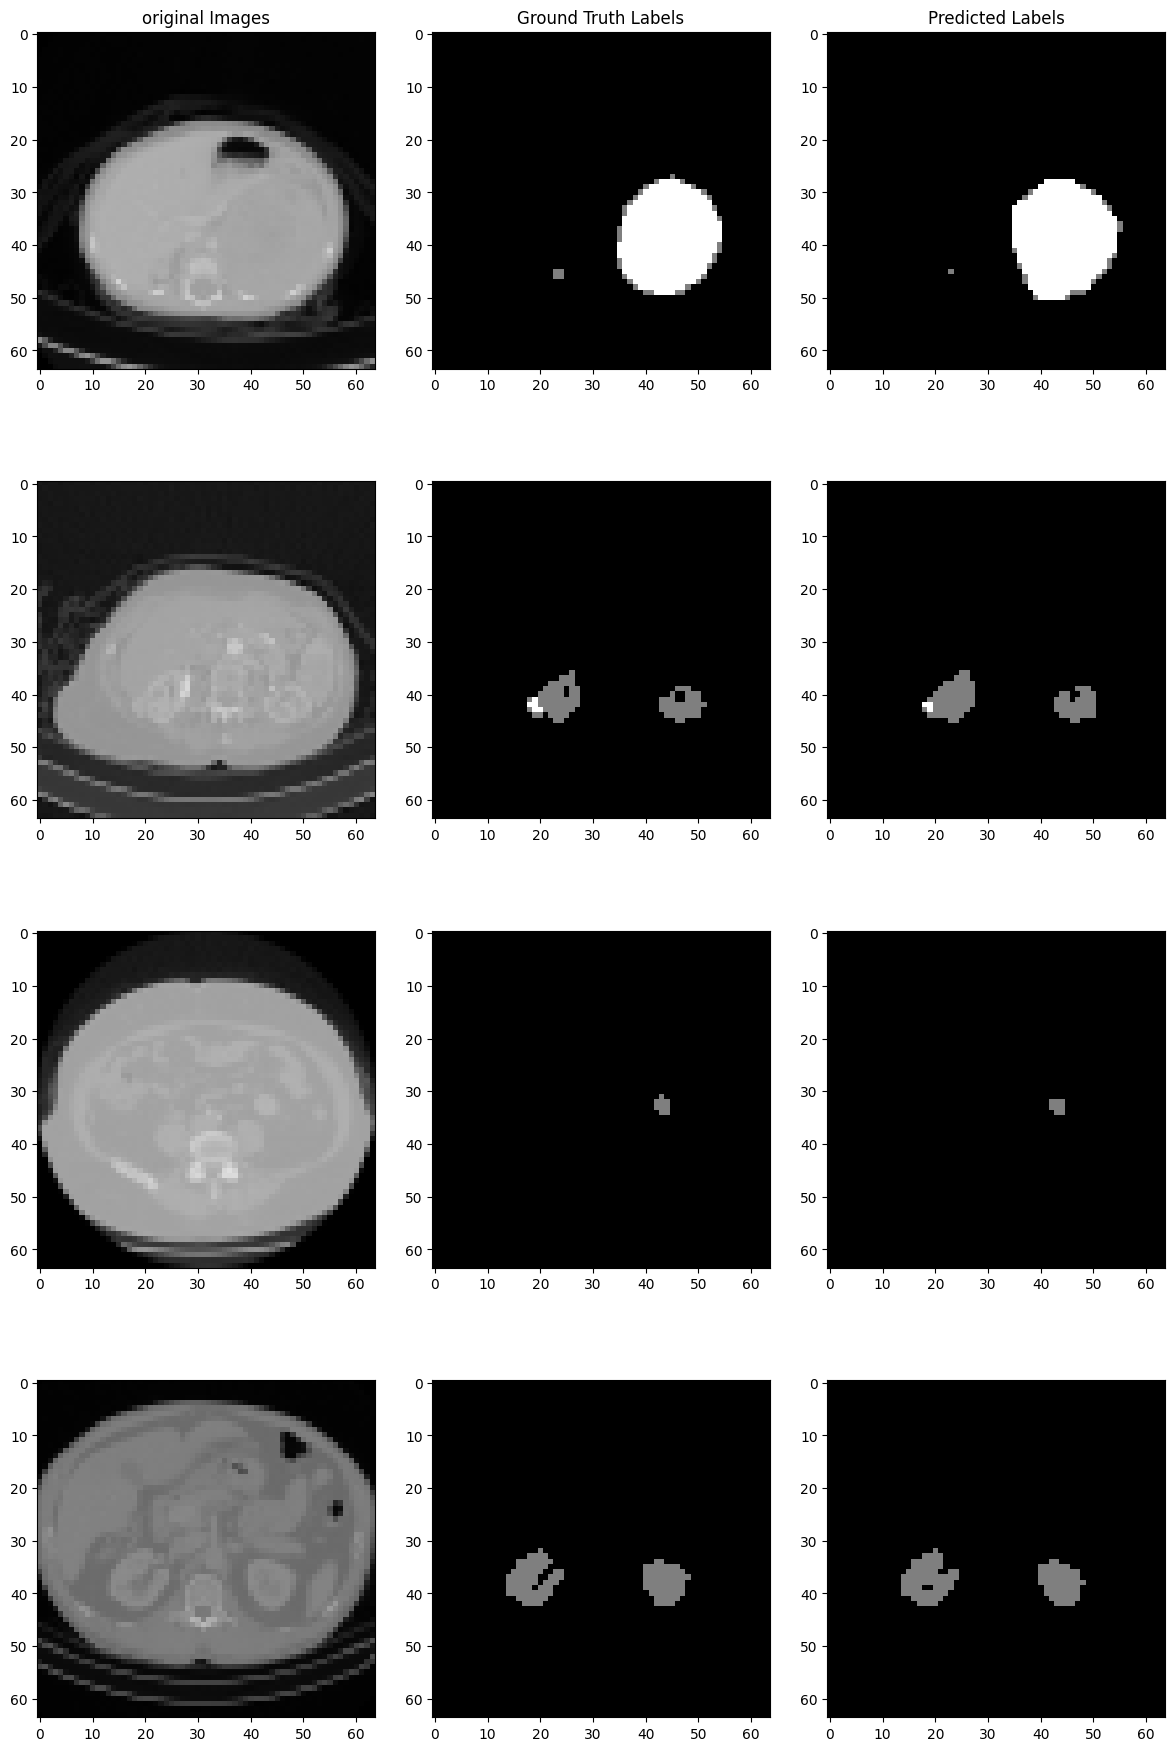

In [88]:
## 120, 170, 180, 230, 260
example_test_data = [test_data[i] for i in np.arange(230, 3000, 800)]

#plt.figure(figsize=(18,12))
fig, ax = plt.subplots(len(example_test_data), 3, figsize=(12, 18))
# fig.set_figheight(6);
# fig.set_figwidth(12);
fig.tight_layout(h_pad=2);

ax[0][0].set_title('original Images')
ax[0][1].set_title('Ground Truth Labels')
ax[0][2].set_title('Predicted Labels')

for i in range(len(example_test_data)):
    img_true = example_test_data[i][0]
    img = img_true[None, :, :, :]
    output = unet(img)               
    output = nn.functional.softmax(output, dim = 1)
    out_labels = torch.max(output, dim = 1).indices
    out_labels = torch.squeeze(out_labels)
    out_labels = (out_labels.detach().numpy()*127.5).astype('uint8')
    out_labels = cv2.cvtColor(out_labels, cv2.COLOR_BGR2RGB)

    true_labels = example_test_data[i][1]
    true_labels = (true_labels.detach().numpy()*127.5).astype('uint8')
    true_labels = cv2.cvtColor(true_labels, cv2.COLOR_BGR2RGB)

    img_true = (torch.squeeze(img_true).detach().numpy()*255).astype('uint8')
    img_true = cv2.cvtColor(img_true, cv2.COLOR_BGR2RGB)

    ax[i][0].imshow(img_true)
    ax[i][1].imshow(true_labels)
    ax[i][2].imshow(out_labels)

## Torch Rough Work

In [15]:
x = torch.randn((1, 3, 4, 4))
print(x);
y = torch.max(x, dim = 1)
y

tensor([[[[ 0.9403,  0.7719,  1.0794, -1.0783],
          [-0.8741,  0.4280,  0.7981,  0.7977],
          [ 0.5731, -0.3422,  0.0182, -1.1181],
          [ 0.7392, -0.2434, -0.3881, -0.9267]],

         [[-0.8489,  1.4813, -0.0867, -0.8130],
          [ 0.0392, -1.3331,  1.7235, -0.2610],
          [-0.1298, -0.9161, -0.1357,  3.2942],
          [-0.6060,  0.5013, -0.5785, -1.2088]],

         [[ 0.4358, -0.2307, -0.4719,  0.5385],
          [ 1.2836,  0.2679, -0.3138, -2.1216],
          [ 0.1118, -0.3626,  1.2301,  0.4903],
          [-0.9737, -0.2090, -0.8946, -0.7493]]]])


torch.return_types.max(
values=tensor([[[ 0.9403,  1.4813,  1.0794,  0.5385],
         [ 1.2836,  0.4280,  1.7235,  0.7977],
         [ 0.5731, -0.3422,  1.2301,  3.2942],
         [ 0.7392,  0.5013, -0.3881, -0.7493]]]),
indices=tensor([[[0, 1, 0, 2],
         [2, 0, 1, 0],
         [0, 0, 2, 1],
         [0, 1, 0, 2]]]))

In [81]:
loss = nn.CrossEntropyLoss()
input = torch.randn(1, requires_grad=True)
print(input)
input.backward()
print(input)
# input = nn.functional.softmax(input)
# print(input)
# target = torch.empty(1, dtype=torch.long).random_(3)
# print(target)
# output = loss(input, target)
# output

tensor([-0.4900], requires_grad=True)
tensor([-0.4900], requires_grad=True)


In [35]:
x = torch.randn((2, 1, 2, 2))
print(x)
y = torch.Tensor([[[[0, 0], [0, 1]], [[1, 0], [0, 0]], [[0, 1], [1, 0]]], [[[1, 1], [0, 0]], [[0, 0], [1, 0]], [[0, 0], [0, 1]]]])
print(y)
print(y.shape)
z = torch.mul(x,y)
print(z)
print(torch.sum(z))

tensor([[[[-0.5102,  0.4540],
          [-1.1849,  1.1663]]],


        [[[-0.5115, -0.3655],
          [-0.0146,  0.6027]]]])
tensor([[[[0., 0.],
          [0., 1.]],

         [[1., 0.],
          [0., 0.]],

         [[0., 1.],
          [1., 0.]]],


        [[[1., 1.],
          [0., 0.]],

         [[0., 0.],
          [1., 0.]],

         [[0., 0.],
          [0., 1.]]]])
torch.Size([2, 3, 2, 2])
tensor([[[[-0.0000,  0.0000],
          [-0.0000,  1.1663]],

         [[-0.5102,  0.0000],
          [-0.0000,  0.0000]],

         [[-0.0000,  0.4540],
          [-1.1849,  0.0000]]],


        [[[-0.5115, -0.3655],
          [-0.0000,  0.0000]],

         [[-0.0000, -0.0000],
          [-0.0146,  0.0000]],

         [[-0.0000, -0.0000],
          [-0.0000,  0.6027]]]])
tensor(-0.3637)


In [34]:
x = torch.randn((2, 3, 2, 2))
print(x)
y = torch.Tensor([[[[0, 0], [0, 1]], [[1, 0], [0, 0]], [[0, 1], [1, 0]]], [[[1, 1], [0, 0]], [[0, 0], [1, 0]], [[0, 0], [0, 1]]]])
print(y.shape)
z = torch.mul(x,y)
print(z.shape)
print(torch.sum(z))

tensor([[[[ 0.7883,  0.0712],
          [ 1.2557, -0.2249]],

         [[-0.5806, -0.1332],
          [-0.9678, -0.4180]],

         [[-0.7863, -1.1898],
          [ 0.3652, -0.6051]]],


        [[[-1.0648, -1.3584],
          [ 0.8919,  0.2630]],

         [[ 0.5256, -0.2173],
          [-0.1505,  1.8619]],

         [[-1.1569,  0.6147],
          [-0.6232, -1.2856]]]])
torch.Size([2, 3, 2, 2])
torch.Size([2, 3, 2, 2])
tensor(-5.4894)


In [31]:
x = torch.randn((2, 2, 2))
print(x)
y = torch.Tensor([[[0, 0], [0, 1]], [[1, 0], [0, 0]]])
print(y.shape)
z = torch.mul(x,y)
print(z)
print(torch.sum(z))

tensor([[[-1.0025, -1.2247],
         [-1.6397,  0.5732]],

        [[-2.2392, -0.7644],
         [ 1.5000, -1.0299]]])
torch.Size([2, 2, 2])
tensor([[[-0.0000, -0.0000],
         [-0.0000,  0.5732]],

        [[-2.2392, -0.0000],
         [ 0.0000, -0.0000]]])
tensor(-1.6660)


tensor([[[   -inf,    -inf],
         [   -inf, -0.2417]],

        [[    nan,    -inf],
         [   -inf,    -inf]]])

In [25]:
x = torch.randn((2, 1, 2, 2))
print(x)
y = x**2
z = torch.sum(y)
z1 = z + z
print(z1)
z2 = torch.tensor(2)
z3 = z2/z1
print(z3)

tensor([[[[-0.9537, -0.2496],
          [-1.4673, -0.0178]]],


        [[[ 1.3093,  0.0227],
          [ 0.8229, -0.8040]]]])
tensor(12.3268)
tensor(0.1622)


In [21]:
x = torch.randn((2, 2, 2, 2))
x1 = x[:, 0, :, :]
print(x1.shape)
x1 = x1[:, None, :, :]
print(x1.shape)

tensor([[[[ 1.0043,  1.0737],
          [ 0.4996, -1.2335]],

         [[ 1.1514, -2.1474],
          [ 1.0749,  0.4478]]],


        [[[-2.0829, -0.8634],
          [-0.1774,  1.4739]],

         [[ 0.4813,  1.3326],
          [-2.0650,  1.2493]]]])
torch.Size([2, 2, 2])
torch.Size([2, 1, 2, 2])
tensor([[[[ 1.0043,  1.0737],
          [ 0.4996, -1.2335]]],


        [[[-2.0829, -0.8634],
          [-0.1774,  1.4739]]]])


In [48]:
unet = UNet()
x = torch.randn((1, 1, 192, 192))
y = unet(x)

torch.Size([1, 30, 192, 192])
torch.Size([1, 60, 96, 96])
torch.Size([1, 120, 48, 48])
torch.Size([1, 240, 24, 24])
torch.Size([1, 320, 12, 12])
torch.Size([1, 480, 6, 6])

torch.Size([1, 640, 12, 12])
torch.Size([1, 320, 12, 12])
torch.Size([1, 480, 24, 24])
torch.Size([1, 240, 24, 24])
torch.Size([1, 240, 48, 48])
torch.Size([1, 120, 48, 48])
torch.Size([1, 120, 96, 96])
torch.Size([1, 60, 96, 96])
torch.Size([1, 60, 192, 192])
torch.Size([1, 30, 192, 192])
torch.Size([1, 3, 192, 192])


C:\Users\PUKHRAJ\AppData\Local\Temp\ipykernel_38548\29590285.py:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = nn.functional.softmax(x_dec_conv6)


In [108]:
x = torch.randn((2, 3, 2, 2))
print(x)
#x1 = torch.randn((2, 3, 3))
#y = torch.cat((x, x1), 0)
y1 = nn.functional.softmax(x, dim = 1)
y1 

tensor([[[[-1.0616, -1.0825],
          [ 0.6276, -0.0519]],

         [[ 0.1739,  0.7869],
          [-2.0334,  1.8480]],

         [[ 0.8959,  0.4952],
          [ 0.1819,  0.7025]]],


        [[[ 2.7887,  0.3892],
          [-0.6484, -0.6492]],

         [[ 1.4715,  0.3408],
          [-1.2464,  1.0920]],

         [[-0.6423, -1.0167],
          [ 0.0054, -0.8040]]]])


tensor([[[[0.0868, 0.0811],
          [0.5847, 0.1019]],

         [[0.2986, 0.5260],
          [0.0409, 0.6814]],

         [[0.6146, 0.3929],
          [0.3744, 0.2167]]],


        [[[0.7691, 0.4550],
          [0.2880, 0.1323]],

         [[0.2060, 0.4335],
          [0.1583, 0.7544]],

         [[0.0249, 0.1115],
          [0.5537, 0.1133]]]])